In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import scipy.io
import glob
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
train_dir = '/content/drive/MyDrive/CMP719/archive/dataset/train'
val_dir = '/content/drive/MyDrive/CMP719/archive/dataset/valid'
test_dir = '/content/drive/MyDrive/CMP719/archive/dataset/test'

#Load Data

In [ ]:
# transformers and data loaders
train_transform = transforms.Compose(
    [transforms.Resize((128,128)),
     transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(),
     transforms.ToTensor()
     ])

val_test_transform = transforms.Compose(
    [transforms.Resize((128,128)),
     transforms.CenterCrop(128),
     transforms.ToTensor(),
     ]
)

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [ ]:
import re

class FlowerTestDataset(Dataset):
    def __init__(self, image_dir, label_mat_path, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
        self.labels = scipy.io.loadmat(label_mat_path)['labels'][0]

        filtered = []

        for img_path in self.image_paths:
            match = re.search(r'(\d+)', os.path.basename(img_path))
            if match:
                idx = int(match.group(1)) - 1
                label = self.labels[idx]
                if 1 <= label <= 20: # since there are 102 classes and we only want classes with id 1-20, it is filtered here
                    filtered.append((img_path, label - 1))

        if not filtered:
            raise ValueError("No images found with labels in the range 1–20.")

        self.image_paths, self.labels = zip(*filtered)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [ ]:
# load test data
test_dir = '/content/drive/MyDrive/CMP719/archive/dataset/test'
test_labels = '/content/drive/MyDrive/CMP719/archive/imagelabels.mat'

test_data = FlowerTestDataset(test_dir, test_labels, transform=val_test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# PART 1 - Modeling and Training a CNN classifier from Scratch

### CNN Architecture

In [ ]:
class MyCNN(nn.Module):
    # dropout is taken as a parameter because it will be tested without regularization (dropout_rate = 0.0)
    def __init__(self, dropout_rate=0.5):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 20)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Model Architecture

- The model is a CNN with 3 convolutional layers followed by 2 fully connected layers.

- Each conv layer uses ReLU activation and is followed by max pooling to reduce spatial size.

- After the final conv layer, the feature map is flattened and passed through a fully connected layer (fc1) with dropout (p=0.5), then another fully connected layer (fc2) outputs scores for 20 classes.

Other Components
- Activation Function:
  - ReLU (fast, prevents vanishing gradient)

- Loss Function:
  - CrossEntropyLoss (suitable for multi-class classification)

- Optimizer:
  - Adam (adaptive learning rate, efficient in practice

In [ ]:
print(f"Number of classes in training dataset: {len(train_data.classes)}")
print(f"Number of classes in validation dataset: {len(val_data.classes)}")
print(f"Number of output neurons in the model: {MyCNN().fc2.out_features}")
print(f"Number of parameters {sum(p.numel() for p in MyCNN().parameters())}")

Number of classes in training dataset: 20
Number of classes in validation dataset: 20
Number of output neurons in the model: 20
Number of parameters 8487252


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# testing on two different learning rates
lrs = [0.01, 0.001]
epochs = 10

# dictionary to store results
results = {}

In [ ]:
# loop over both regularized and non-regularized models
for regularized in [False, True]:
    reg_type = "With Regularization" if regularized else "No Regularization"
    print(f"\n--- Training Model ({reg_type}) ---")

    for lr in lrs:
        print(f"\n  -> Training with Learning Rate: {lr}")
        if regularized:
          drop_out = 0.5
          weight_decay = 1e-5
        else:
          drop_out = 0.0
          weight_decay = 0.0

        model = MyCNN(dropout_rate=drop_out).to(device)
        optimizer = optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

        # record both loss and accuracy to plot
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(epochs):
            model.train()
            correct, total = 0, 0
            running_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader.dataset)
            train_acc = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # validation
            model.eval()
            correct, total = 0, 0
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss = val_running_loss / len(val_loader.dataset)
            val_acc = correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f"    Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Accuracy={train_acc:.4f}, Val Accuracy={val_acc:.4f}")

        results[(reg_type, lr)] = {
            "train_loss": train_losses,
            "val_loss": val_losses,
            "train_acc": train_accuracies,
            "val_acc": val_accuracies
        }


--- Training Model (No Regularization) ---

  -> Training with Learning Rate: 0.01
    Epoch 1: Train Loss=5.0294, Val Loss=2.9298, Train Accuracy=0.0740, Val Accuracy=0.0901
    Epoch 2: Train Loss=2.7791, Val Loss=2.6522, Train Accuracy=0.1372, Val Accuracy=0.1622
    Epoch 3: Train Loss=2.5406, Val Loss=2.5560, Train Accuracy=0.1983, Val Accuracy=0.2342
    Epoch 4: Train Loss=2.3816, Val Loss=2.6165, Train Accuracy=0.2519, Val Accuracy=0.2162
    Epoch 5: Train Loss=2.2361, Val Loss=2.1245, Train Accuracy=0.3205, Val Accuracy=0.3243
    Epoch 6: Train Loss=2.0669, Val Loss=2.2568, Train Accuracy=0.3333, Val Accuracy=0.2613
    Epoch 7: Train Loss=1.9530, Val Loss=2.2132, Train Accuracy=0.3794, Val Accuracy=0.2883
    Epoch 8: Train Loss=1.8367, Val Loss=2.0807, Train Accuracy=0.4169, Val Accuracy=0.3063
    Epoch 9: Train Loss=1.8203, Val Loss=2.0723, Train Accuracy=0.4191, Val Accuracy=0.3784
    Epoch 10: Train Loss=1.7294, Val Loss=2.0704, Train Accuracy=0.4491, Val Accuracy=0.

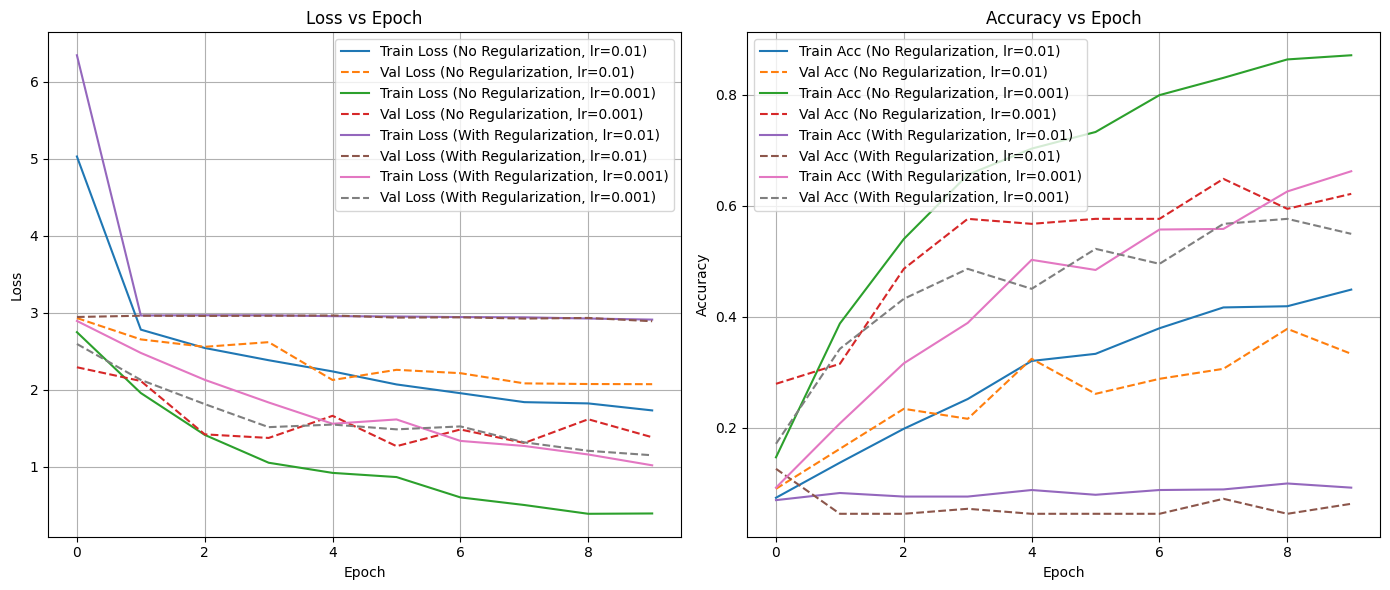

In [ ]:
# plotting loss and cccuracy
plt.figure(figsize=(14, 6))

# loss
plt.subplot(1, 2, 1)
for key in results:
    plt.plot(results[key]['train_loss'], label=f"Train Loss ({key[0]}, lr={key[1]})")
    plt.plot(results[key]['val_loss'], linestyle='--', label=f"Val Loss ({key[0]}, lr={key[1]})")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
for key in results:
    plt.plot(results[key]['train_acc'], label=f"Train Acc ({key[0]}, lr={key[1]})")
    plt.plot(results[key]['val_acc'], linestyle='--', label=f"Val Acc ({key[0]}, lr={key[1]})")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

It can be seen above that, learning rate 0.001 has lower loss and higher accuracy than 0.01. And model without regularization performs slightly better witth regularization.  

It can be naturally expected because a smaller learning rate leads to more gradual and stabel updates on the weights. Higher learning rate can cause missing the minima.

While regularization (e.g., weight decay) aims to improve generalization, its impact here is limited. With lr=0.001, the non-regularized model slightly outperforms the regularized one in training, though regularization helps reduce overfitting slightly in validation accuracy. At lr=0.01, both models perform bad, and regularization offers no visible benefit.

### Selecting The Best Model


In [ ]:
# selecting the best model
final_lr = 0.001
final_dropout_rate = 0.0
final_weight_decay = 0.0
model = MyCNN(dropout_rate= final_dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=final_lr, weight_decay=final_weight_decay)


In [ ]:
# final training with best settings
train_accs, val_accs, train_losses, val_losses = [], [], [], []
epochs = 10
for epoch in range(epochs):
    model.train()
    correct, running_loss = 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    train_accs.append(correct / len(train_loader.dataset))
    train_losses.append(running_loss / len(train_loader.dataset))

    # validation
    model.eval()
    correct, running_loss = 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_accs.append(correct / len(val_loader.dataset))
    val_losses.append(running_loss / len(val_loader.dataset))

    print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")


Epoch 1: Train Acc=0.1179, Val Acc=0.2883
Epoch 2: Train Acc=0.3194, Val Acc=0.3604
Epoch 3: Train Acc=0.4427, Val Acc=0.4685
Epoch 4: Train Acc=0.5016, Val Acc=0.4505
Epoch 5: Train Acc=0.6066, Val Acc=0.4685
Epoch 6: Train Acc=0.6302, Val Acc=0.4955
Epoch 7: Train Acc=0.6795, Val Acc=0.5495
Epoch 8: Train Acc=0.7320, Val Acc=0.5225
Epoch 9: Train Acc=0.7674, Val Acc=0.5045
Epoch 10: Train Acc=0.8189, Val Acc=0.5045


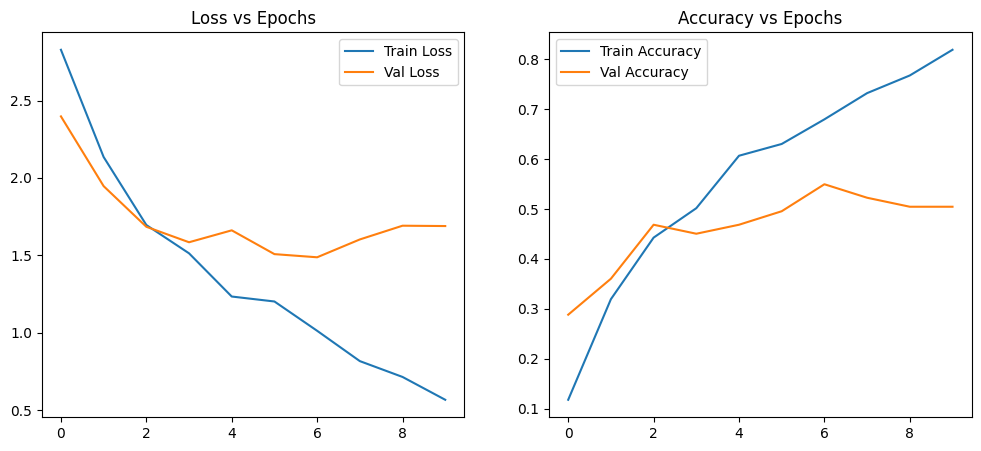

In [ ]:
# Plot final training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Testing on Test Data

In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader: # test loader defined on top
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Final Test Accuracy: {test_acc:.10f}")

Final Test Accuracy: 0.0180180180


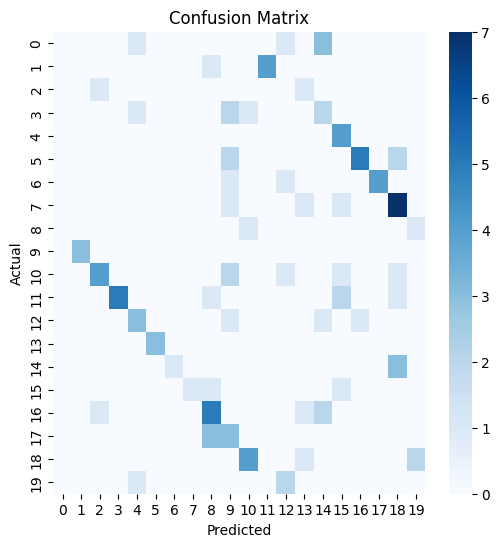

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# PART 2 - Transfer Learning with CNNs


### EfficientNet (All Layers Frreze)


In [ ]:
# --- load pretrained EfficientNet ---
def get_model(freeze_all=True, unfreeze_last_n=0):
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    if not freeze_all:
        ct = 0
        for child in model.features.children():
            ct += 1
            if ct > len(model.features) - unfreeze_last_n:
                for param in child.parameters():
                    param.requires_grad = True

    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, 20)
    return model

In [ ]:
# --- training function ---
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, save_path='model.pth'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader.dataset))
        val_acc = correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# train model with frozen layers (only FC trainable)
frozen_model = get_model(freeze_all=True)
frozen_results = train_model(frozen_model, train_loader, val_loader, epochs=10, lr=0.001, save_path="best_frozen.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 38.3MB/s]


Epoch 1: Train Loss=2.3191, Val Loss=1.6873, Train Acc=0.4277, Val Acc=0.7387
Epoch 2: Train Loss=1.2206, Val Loss=1.1432, Train Acc=0.8360, Val Acc=0.8018
Epoch 3: Train Loss=0.8073, Val Loss=0.9114, Train Acc=0.9014, Val Acc=0.8288
Epoch 4: Train Loss=0.6227, Val Loss=0.7794, Train Acc=0.9218, Val Acc=0.8649
Epoch 5: Train Loss=0.4980, Val Loss=0.6853, Train Acc=0.9389, Val Acc=0.8649
Epoch 6: Train Loss=0.4166, Val Loss=0.6108, Train Acc=0.9421, Val Acc=0.8559
Epoch 7: Train Loss=0.3662, Val Loss=0.6155, Train Acc=0.9528, Val Acc=0.8739
Epoch 8: Train Loss=0.3226, Val Loss=0.5821, Train Acc=0.9561, Val Acc=0.8739
Epoch 9: Train Loss=0.2969, Val Loss=0.5377, Train Acc=0.9539, Val Acc=0.8739
Epoch 10: Train Loss=0.2701, Val Loss=0.5300, Train Acc=0.9507, Val Acc=0.8649


In [ ]:
# Train model with unfrozen last 4 layers
unfrozen_model = get_model(freeze_all=False, unfreeze_last_n=4)
unfrozen_results = train_model(unfrozen_model, train_loader, val_loader, epochs=10, lr=0.001, save_path="best_unfrozen.pth")

Epoch 1: Train Loss=1.2720, Val Loss=0.2547, Train Acc=0.6817, Val Acc=0.9009
Epoch 2: Train Loss=0.1714, Val Loss=0.2351, Train Acc=0.9561, Val Acc=0.9099
Epoch 3: Train Loss=0.1110, Val Loss=0.3586, Train Acc=0.9668, Val Acc=0.9099
Epoch 4: Train Loss=0.1076, Val Loss=0.1790, Train Acc=0.9678, Val Acc=0.9369
Epoch 5: Train Loss=0.1179, Val Loss=0.2535, Train Acc=0.9646, Val Acc=0.9369
Epoch 6: Train Loss=0.0601, Val Loss=0.2789, Train Acc=0.9775, Val Acc=0.9189
Epoch 7: Train Loss=0.0859, Val Loss=0.1888, Train Acc=0.9743, Val Acc=0.9369
Epoch 8: Train Loss=0.1319, Val Loss=0.5048, Train Acc=0.9636, Val Acc=0.8829
Epoch 9: Train Loss=0.1359, Val Loss=0.2888, Train Acc=0.9646, Val Acc=0.9459
Epoch 10: Train Loss=0.0624, Val Loss=0.2728, Train Acc=0.9818, Val Acc=0.9369


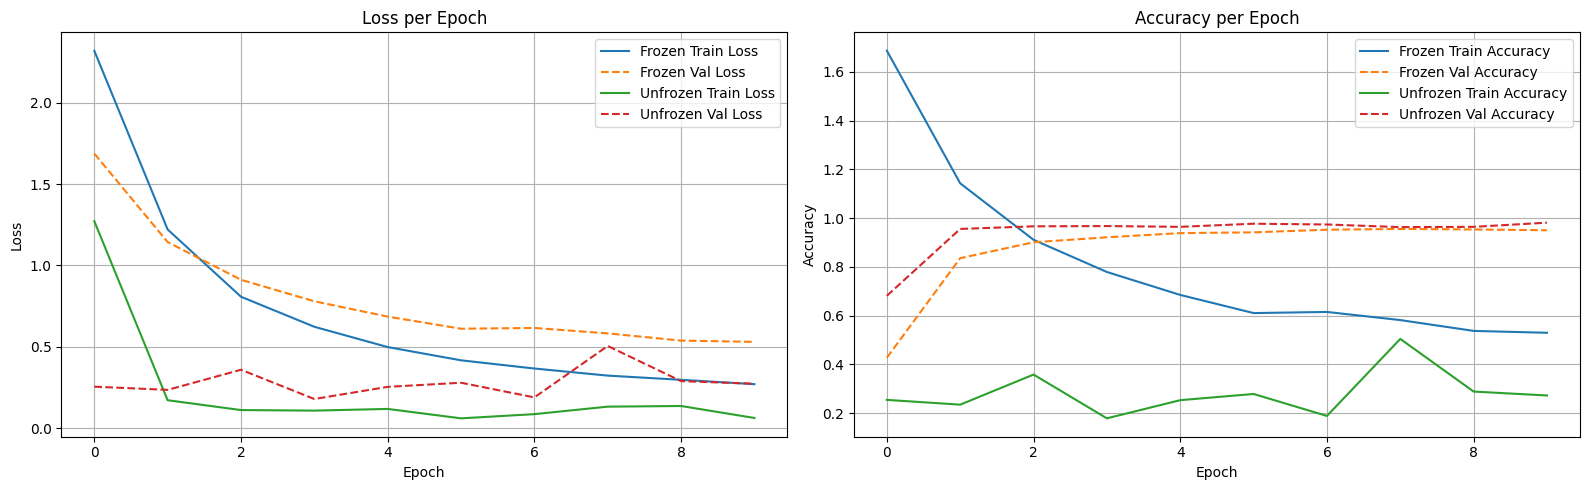

In [ ]:
def plot_metrics(frozen_results, unfrozen_results):
    metrics = ["Loss", "Accuracy"]
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

    for i, name in enumerate(metrics):
        ax = axes[i]
        ax.plot(frozen_results[i], label=f"Frozen Train {name}")
        ax.plot(frozen_results[i+1], linestyle='--' , label=f"Frozen Val {name}")
        ax.plot(unfrozen_results[i], label=f"Unfrozen Train {name}")
        ax.plot(unfrozen_results[i+1], linestyle='--' ,label=f"Unfrozen Val {name}")
        ax.set_title(f"{name} per Epoch")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(name)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(frozen_results, unfrozen_results)

The plots show that the frozen model trains more stably, with smoothly decreasing loss and steadily improving validation accuracy, suggesting good generalization. In contrast, the unfrozen model shows fluctuating training loss and accuracy, indicating instability and potential overfitting. Interestingly, its validation accuracy remains high and stable, which may be due to regularization or data imbalance. Overall, the frozen model offers more consistent performance, while the unfrozen model needs careful tuning to improve reliability.

Test on Test Data

In [ ]:
# Load and evaluate best model
model = get_model(freeze_all=False, unfreeze_last_n=4)
model.load_state_dict(torch.load("best_frozen.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Final Test Accuracy (Best Model): {test_acc:.4f}")


Final Test Accuracy (Best Model): 0.0450


# PART 3 - CNNs with Self Attention

Self Attention Module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query_conv(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(B, -1, H * W)
        attention = torch.bmm(proj_query, proj_key)
        attention = F.softmax(attention, dim=-1)

        proj_value = self.value_conv(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)

        return self.gamma * out + x  # residual connection

In [ ]:
class MyCNNWithAttention(nn.Module):
    def __init__(self, dropout_rate=0.5, attention_at=[2]):
        super(MyCNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)

        #attention layers
        self.att1 = SelfAttention(32)
        self.att2 = SelfAttention(64)
        self.att3 = SelfAttention(128)
        self.attention_at = attention_at

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if 1 in self.attention_at:
            x = self.att1(x)

        x = self.pool(F.relu(self.conv2(x)))
        if 2 in self.attention_at:
            x = self.att2(x)

        x = self.pool(F.relu(self.conv3(x)))
        if 3 in self.attention_at:
            x = self.att3(x)

        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
def run_training(model, train_loader, val_loader, epochs=10, lr=0.001):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(train_loss / len(train_loader.dataset))
        train_accs.append(train_correct / len(train_loader.dataset))

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accs.append(val_correct / len(val_loader.dataset))

        print(f"Epoch {epoch+1}: Train Acc {train_accs[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")

    return model, train_losses, val_losses, train_accs, val_accs

### Experiments

In [ ]:
# Experiment 1: Attention after conv2
model_att2 = MyCNNWithAttention(attention_at=[2])
trained_model2, tl2, vl2, ta2, va2 = run_training(model_att2, train_loader, val_loader)

Epoch 1: Train Acc 0.1522, Val Acc 0.3333
Epoch 2: Train Acc 0.3751, Val Acc 0.4054
Epoch 3: Train Acc 0.4930, Val Acc 0.5135
Epoch 4: Train Acc 0.5413, Val Acc 0.5766
Epoch 5: Train Acc 0.5895, Val Acc 0.5225
Epoch 6: Train Acc 0.6377, Val Acc 0.6847
Epoch 7: Train Acc 0.6731, Val Acc 0.5856
Epoch 8: Train Acc 0.6570, Val Acc 0.6396
Epoch 9: Train Acc 0.7342, Val Acc 0.7027
Epoch 10: Train Acc 0.7513, Val Acc 0.5856


In [ ]:
# Experiment 2: Attention after conv1 and conv3
model_att13 = MyCNNWithAttention(attention_at=[1, 3])
trained_model13, tl13, vl13, ta13, va13 = run_training(model_att13, train_loader, val_loader)

Epoch 1: Train Acc 0.1436, Val Acc 0.2342
Epoch 2: Train Acc 0.2583, Val Acc 0.4054
Epoch 3: Train Acc 0.4469, Val Acc 0.5045
Epoch 4: Train Acc 0.5316, Val Acc 0.6126
Epoch 5: Train Acc 0.5949, Val Acc 0.6216
Epoch 6: Train Acc 0.6549, Val Acc 0.6306
Epoch 7: Train Acc 0.6827, Val Acc 0.6036
Epoch 8: Train Acc 0.7213, Val Acc 0.6306
Epoch 9: Train Acc 0.7546, Val Acc 0.6396
Epoch 10: Train Acc 0.7771, Val Acc 0.6577


In [ ]:
def plot_metrics_comparison(results1, results2, label1='Model 1', label2='Model 2'):
    train_loss1, val_loss1, train_acc1, val_acc1 = results1
    train_loss2, val_loss2, train_acc2, val_acc2 = results2

    plt.figure(figsize=(14, 6))

    # Loss per epoch
    plt.subplot(1, 2, 1)
    plt.plot(train_loss1, label=f'{label1} Train Loss', linestyle='-')
    plt.plot(val_loss1, label=f'{label1} Val Loss', linestyle='--')
    plt.plot(train_loss2, label=f'{label2} Train Loss', linestyle='-')
    plt.plot(val_loss2, label=f'{label2} Val Loss', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.grid(True)

    # Accuracy per epoch
    plt.subplot(1, 2, 2)
    plt.plot(train_acc1, label=f'{label1} Train Accuracy', linestyle='-')
    plt.plot(val_acc1, label=f'{label1} Val Accuracy', linestyle='--')
    plt.plot(train_acc2, label=f'{label2} Train Accuracy', linestyle='-')
    plt.plot(val_acc2, label=f'{label2} Val Accuracy', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

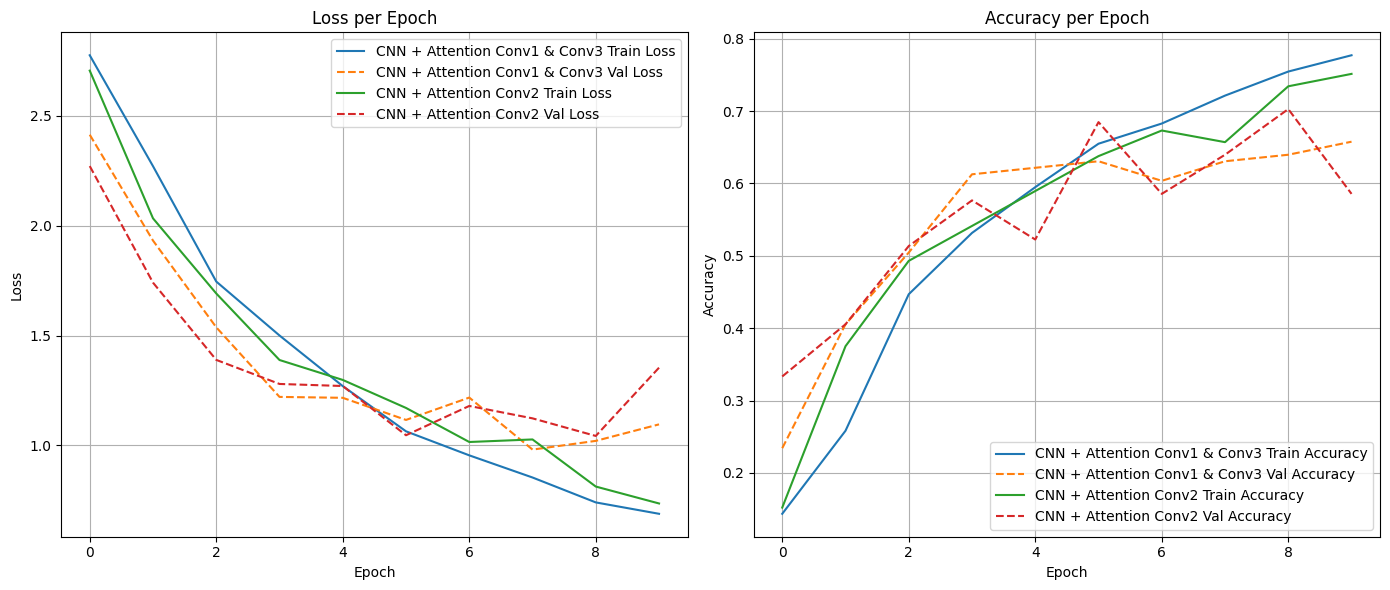

In [ ]:
plot_metrics_comparison(
    results1=(tl13, vl13, ta13, va13),
    results2=(tl2, vl2, ta2, va2),
    label1='CNN + Attention Conv1 & Conv3',
    label2='CNN + Attention Conv2'
)

Attention after Conv2 performs better because it catches mid-level features, which are more complex than basic edges (Conv1) but not totally abstract (Conv3). At this point, the feature maps are dense enough to benefit from attention, allowing the model to concentrate on key spatial regions while maintaining enough resolution.

In contrast, applying attention after Conv1 may be too early, as features are still basic, and after Conv3 may be too late, as feature maps are greatly compressed, reducing the spatial information on which attention mechanisms depend. So, focusing attention after Conv2 achieves a better balance of content and spatial information.

Test on Test Data

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {acc:.4f}")
    return acc


print("Attention after Conv2:")
evaluate(trained_model2, test_loader)

print("Attention after Conv1 & Conv3:")
evaluate(trained_model13, test_loader)

Attention after Conv2:
Test Accuracy: 0.0360
Attention after Conv1 & Conv3:
Test Accuracy: 0.0180


np.float64(0.018018018018018018)

# Conclusion

For the first part with custom CNN model:
- Decreasing learning rate increased the models performance.
- Expected outcome of adding regularization to the model was increasing the performance by reducing overfitting and improve generalization. However, it slightly decreased the performance.
  - possible reasons for this can be the size of data. If it was small, adding dropout might effect its ability to learn. Maybe model didn't have time to learn (less epoch) or preventing overfitting might be unnecesarry since model was not overfiting from the beginning.



For the EfficientNet - Frozen vs Unfrozen:
- Expected outcome was learning better with unfreezing, but this can rissk overfitting without enough data.
- Outcomes matches with the expected result. Unfreezing improved training accuracy but unfortunately decreased the validation accuracy a bit.

Self-Attention - Conv2 vs Con1&3
- Attention should help the model with focusing on more important features and should improve validation accuracy.
- Conv1&3 attention helped better for later parts of the experiment, but Con2 was better in earlier parts of the experiment.

**General Conclusion**

Throughout the experiments, first results show that, even though regularization is a powerful helper, its effects may not be always useful. In our case of custom CNN, adding regularization make the situation slightly worse, possibly because of the data's limited capacity. On the other hand, the EfficientNet experiments confirmed that frozen models are better in generalization but unfrozen models achive higher train accuracy but risk overfitting. And lastly, adding self attention improved the performance especially when added after Conv1 & Conv3. This makes it more clear that benefit of capturing low and high level together.